In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
import glob
import pathlib

import matplotlib.pyplot as plt

sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [5]:
dfs = {}
symbols = []
for i in glob.glob("../data/futures/*"):
    # print(pathlib.Path(i).name[:-4])
    symbol = pathlib.Path(i).name[:-4]
    dfs[symbol] = pd.read_csv(i)
    symbols.append(symbol)
    break

dfs.keys()

dict_keys(['A0.dce'])

In [13]:
# if0_df = pd.read_csv("../data/IF0.cffex.csv") # 沪深300指数期货连续
# ih0_df = pd.read_csv("../data/IH0.cffex.csv") # 上证50指数期货连续
# ic0_df = pd.read_csv("../data/IC0.cffex.csv") # 中证500指数期货连续


# sc0_df = pd.read_csv("../data/SC0.ine.csv")
# lh0_df = pd.read_csv("../data/LH0.dce.csv")

# if0_df.shape, ih0_df.shape, ic0_df.shape, sc0_df.shape, lh0_df.shape

In [4]:
# df = pd.concat([if0_df, ih0_df, ic0_df, sc0_df, lh0_df]).reset_index(drop=True)


(3052, 6)

# feature

In [13]:
df = deepcopy(dfs.get(symbols[0]))
df.shape

# volume check
volume_change = df.loc[1:,"volume"].values - df.loc[:(df.shape[0]-2),"volume"].values
volume_change_rate = volume_change / df.loc[:(df.shape[0]-2),"volume"].values * 100
df["volume_change"] = np.hstack([[0], volume_change_rate])
df = df[~((df["volume_change"] > 300) | (df["volume_change"] < -300))].reset_index(drop=True)
print(df.head())

def get_change(df, base="open"):
    base_change = df.loc[1:,base].values - df.loc[:(df.shape[0]-2),base].values
    base_change_rate = base_change / df.loc[:(df.shape[0]-2),base].values*100
    return np.hstack([[0], base_change_rate])
    
for col in ["close","open","high","low"]:
    df[col+"_change"] = get_change(df, base=col)

# open 相对前日 close
open_close_change = df.loc[1:,"open"].values - df.loc[:(df.shape[0]-2),"close"].values
open_close_change_rate = open_close_change / df.loc[:(df.shape[0]-2),"close"].values * 100
df["open_close_change"] = np.hstack([[0], open_close_change_rate])

# 当日：开盘 收盘 最高 最低 差值 波动, 以开盘价和收盘价为基准
df["high_open_rate"] = (df["high"] - df["open"]) / df["open"] * 100
df["low_open_rate"] = (df["low"] - df["open"]) / df["open"] * 100
df["close_open_rate"] = (df["close"] - df["open"]) / df["open"] * 100
df["high_close_rate"] = (df["high"] - df["close"]) / df["close"] * 100
df["low_close_rate"] = (df["low"] - df["close"]) / df["close"] * 100

labels = []
for cc,co in zip(np.hstack([df["close_change"].values[1:], [0]]),
                 np.hstack([df["close_open_rate"].values[1:], [0]])):
    if cc > 0 and co > 0:
        label = 1
    else:
        label = 0
    labels.append(label)
df["label"] = labels
# df["label"] = np.hstack([df["close_open_rate"].values[1:], [0]]) # df["close"] - df["open"].apply(lambda x:1 if x>0 else 0)
df = df.drop(0, axis=0).reset_index(drop=True)
df = df.drop([len(df)-1], axis=0).reset_index(drop=True)
    
# df = df.drop(["open","high","low","close","volume"], axis=1)
df.head()

     datetime  open  high   low  close  volume  volume_change
0  2010-01-04  4080  4090  4049   4057  321838       0.000000
1  2010-01-05  4067  4082  4060   4066  253640     -21.190164
2  2010-01-06  4066  4194  4057   4154  860812     239.383378
3  2010-01-07  4165  4188  3975   4044  705704     -18.018801
4  2010-01-08  4040  4050  3947   3981  526594     -25.380329


C:\Users\rosey\AppData\Local\Temp\ipykernel_6852\150009540.py:6: RuntimeWarning: divide by zero encountered in divide
  volume_change_rate = volume_change / df.loc[:(df.shape[0]-2),"volume"].values * 100


,datetime,open,high,low,close,volume,volume_change,close_change,open_change,high_change,low_change,open_close_change,high_open_rate,low_open_rate,close_open_rate,high_close_rate,low_close_rate,label
0,2010-01-05,4067,4082,4060,4066,253640,-21.190164,0.221839,-0.318627,-0.195599,0.271672,0.246488,0.368822,-0.172117,-0.024588,0.393507,-0.147565,1
1,2010-01-06,4066,4194,4057,4154,860812,239.383378,2.164289,-0.024588,2.743753,-0.073892,0.000000,3.148057,-0.221348,2.164289,0.962927,-2.335099,0
2,2010-01-07,4165,4188,3975,4044,705704,-18.018801,-2.648050,2.434825,-0.143062,-2.021198,0.264805,0.552221,-4.561825,-2.905162,3.560831,-1.706231,0
3,2010-01-08,4040,4050,3947,3981,526594,-25.380329,-1.557864,-3.001200,-3.295129,-0.704403,-0.098912,0.247525,-2.301980,-1.460396,1.733233,-0.854057,1
4,2010-01-11,4012,4050,4012,4031,316116,-39.969692,1.255966,-0.693069,0.000000,1.646820,0.778699,0.947159,0.000000,0.473579,0.471347,-0.471347,0


In [8]:
df.loc[1:,"open"].shape

(3016,)

In [9]:
df["volume"].describe()

count    3.017000e+03
mean     1.722095e+05
std      1.432339e+05
min      0.000000e+00
25%      9.605600e+04
50%      1.397140e+05
75%      2.052270e+05
max      2.197400e+06
Name: volume, dtype: float64

In [10]:
mean, std = df["volume"].mean(), df["volume"].std()

In [11]:
df[((df["volume"] > (mean+3*std)) | (df["volume"] < -(mean+3*std)))].shape

(57, 18)

In [106]:
df[((df["volume_change"] > 300) | (df["volume_change"] < -300))].shape

(33, 18)

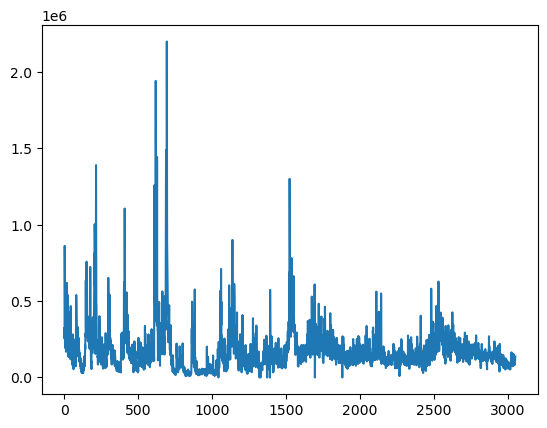

In [45]:
plt.plot(np.arange(df.shape[0]), df["volume"].values)

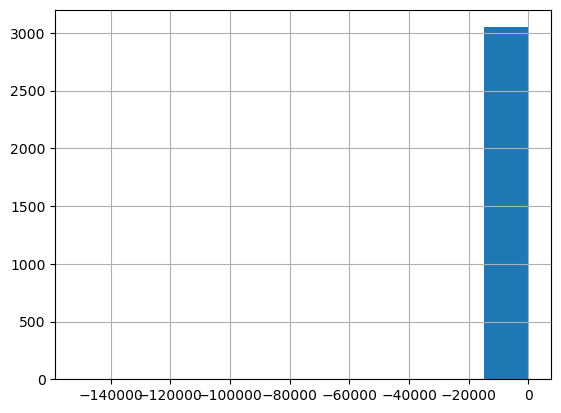

In [19]:
df["volume_change"].hist()

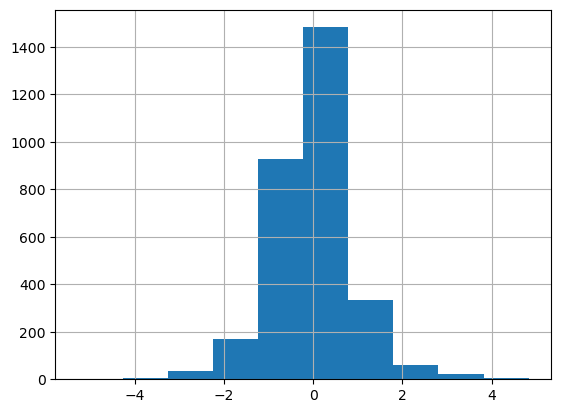

In [16]:
df["label"].hist()

In [8]:
dfs.get(symbols[0])

,datetime,open,high,low,close,volume
0,2010-01-04,4080,4090,4049,4057,321838
1,2010-01-05,4067,4082,4060,4066,253640
2,2010-01-06,4066,4194,4057,4154,860812
3,2010-01-07,4165,4188,3975,4044,705704
4,2010-01-08,4040,4050,3947,3981,526594
...,...,...,...,...,...,...
3047,2022-07-26,5727,5880,5727,5874,121318
3048,2022-07-27,5880,5920,5862,5910,84926
3049,2022-07-28,5935,6006,5911,5972,101523
3050,2022-07-29,5972,6100,5964,6092,119223


## analyse

In [69]:
df["volume_change"].replace(-np.inf, 0, inplace=True)

In [71]:
df.iloc[1370, :]

datetime             2015-09-02
label                         1
close_change           0.190976
open_close_change     -0.262593
open_change             0.28777
high_change             0.09517
low_change             0.408457
volume_change        -42.250457
high_open_rate         0.007914
low_open_rate         -0.001918
close_open_rate        0.004556
high_close_rate        0.003342
low_close_rate        -0.006445
Name: 1370, dtype: object

In [73]:
df.head()

,datetime,label,close_change,open_close_change,open_change,high_change,low_change,volume_change,high_open_rate,low_open_rate,close_open_rate,high_close_rate,low_close_rate
0,2010-01-04,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002451,-0.007598,-0.005637,0.008134,-0.001972
1,2010-01-05,0,0.221348,0.245942,-0.319646,-0.195982,0.270936,-26.887715,0.003688,-0.001721,-0.000246,0.003935,-0.001476
2,2010-01-06,1,2.118440,0.000000,-0.024594,2.670482,-0.073946,70.534797,0.031481,-0.002213,0.021643,0.009629,-0.023351
3,2010-01-07,0,-2.720079,0.272008,2.376951,-0.143266,-2.062893,-21.979187,0.005522,-0.045618,-0.029052,0.035608,-0.017062
4,2010-01-08,0,-1.582517,-0.100477,-3.094059,-3.407407,-0.709400,-34.012921,0.002475,-0.023020,-0.014604,0.017332,-0.008541


array([[<AxesSubplot:title={'center':'label'}>,
        <AxesSubplot:title={'center':'close_change'}>,
        <AxesSubplot:title={'center':'open_close_change'}>],
       [<AxesSubplot:title={'center':'open_change'}>,
        <AxesSubplot:title={'center':'high_change'}>,
        <AxesSubplot:title={'center':'low_change'}>],
       [<AxesSubplot:title={'center':'volume_change'}>,
        <AxesSubplot:title={'center':'high_open_rate'}>,
        <AxesSubplot:title={'center':'low_open_rate'}>],
       [<AxesSubplot:title={'center':'close_open_rate'}>,
        <AxesSubplot:title={'center':'high_close_rate'}>,
        <AxesSubplot:title={'center':'low_close_rate'}>]], dtype=object)

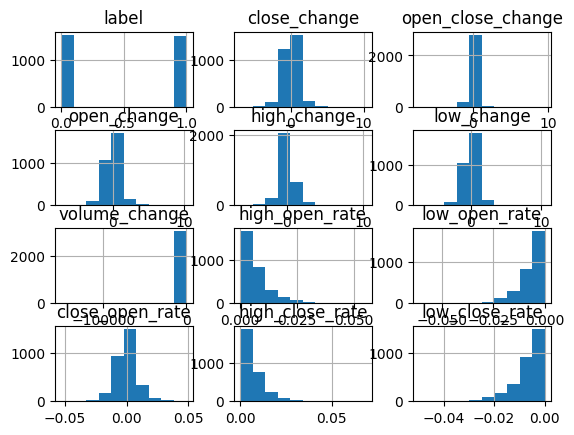

In [74]:
df.hist()

In [91]:
sorted(dfs.items(), key=lambda x:x[0].split(".")[1])

[('IC0.cffex',
          datetime    open    high     low   close  volume  label    change
  0     2017-01-17  5998.0  6070.0  5956.8  6065.0    8087      1  0.000000
  1     2017-01-18  6059.0  6105.0  6038.0  6073.8    7472      1  0.144885
  2     2017-01-19  6063.4  6093.4  6026.6  6047.0    6053      0 -0.443195
  3     2017-01-20  5988.0  6108.0  5983.0  6082.8    8844      1  0.588545
  4     2017-01-23  6095.0  6157.6  6095.0  6114.2    6444      1  0.513559
  ...          ...     ...     ...     ...     ...     ...    ...       ...
  1340  2022-07-26  6191.0  6296.6  6175.4  6273.4   61431      1  1.590844
  1341  2022-07-27  6267.6  6317.0  6244.0  6298.0   47615      1  0.390600
  1342  2022-07-28  6335.0  6381.0  6298.0  6305.6   56115      0  0.120528
  1343  2022-07-29  6320.0  6343.8  6245.4  6255.2   55401      0 -0.805730
  1344  2022-08-01  6254.0  6318.0  6211.2  6311.4   55624      1  0.890452
  
  [1345 rows x 8 columns]),
 ('IF0.cffex',
          datetime    open 

In [89]:
dfs = sorted(dfs.items(), key=lambda x:x[0].split(".")[1])
for name, df in dfs.items():
    # window = 30
    change = df.loc[1:,"close"].values - df.loc[:(df.shape[0]-2),"close"].values
    change = np.hstack([[0], change])

    df["label"] = (df["close"] - df["open"]).apply(lambda x:1 if x>0 else 0)
    df["change"] = (change / df.loc[:,"close"].values) * 100

    for window in [30,60,90,120]:
        up_values, up_count = 0,1
        down_values, down_count = 0,1
        for i in range(window, df.shape[0]-window):
            if df.loc[i+window,"label"] == 1:
                up_values += df.drop(["label","datetime"],axis=1).iloc[i:window+i,:].reset_index(drop=True)
                up_count += 1
            else:
                down_values += df.drop(["label","datetime"],axis=1).iloc[i:window+i,:].reset_index(drop=True)
                down_count += 1
            # break

        up_values = up_values / up_count
        down_values = down_values / down_count

        print(name, up_count, down_count, df["change"].mean())

        # plt.plot(up_values["change"], label="up_change")
        # plt.plot(down_values["change"], label="down_change")
        # plt.legend()
        # plt.title(name)
        # plt.show()

A0.dce 1487 1507 0.008062431153526303
AG0.shfe 1168 1267 -0.025160755269420895
AL0.shfe 1456 1543 -0.0033882895003834444
AP0.czce 514 544 -0.02542602465328782
AU0.shfe 1540 1464 0.01007966316685011
B0.dce 1304 1541 -0.00864360274776696
BB0.dce 381 608 -0.011905254321659
BC0.ine 185 170 0.023008864802197524
BU0.shfe 1000 1087 -0.024802006827651494
C0.dce 1453 1543 0.0035848817934705703
CF0.czce 1458 1538 -0.013360508879966683
CJ0.czce 336 395 0.0029977020470109902
CS0.dce 849 943 -14.742565178854774
CU0.shfe 1508 1493 -0.007316328733514354
CY0.czce 521 588 -0.013042894405675987
EB0.dce 314 317 -0.010117656745394039
EG0.dce 410 415 -0.049908435412011204
FB0.dce 705 1017 -0.04766073668053992
FG0.czce 1132 1149 -0.00864750989607968
FU0.shfe 1042 1931 -0.03826173811391067
HC0.shfe 1019 964 -0.004843847877696872
I0.dce 1067 1015 -0.05234824675443359
IC0.cffex 658 629 -0.007698189322450675
IF0.cffex 632 655 0.008322745045556145
IH0.cffex 630 657 0.004554803770086661
IM0.cffex 1 1 0.3604580052

In [81]:
import matplotlib.pyplot as plt

In [84]:
# plt.plot(up_values["open"], label="up_open")
# plt.plot(up_values["close"], label="up_close")
# plt.plot(down_values["open"], label="down_open")
# plt.plot(down_values["close"], label="down_close")
# plt.legend()

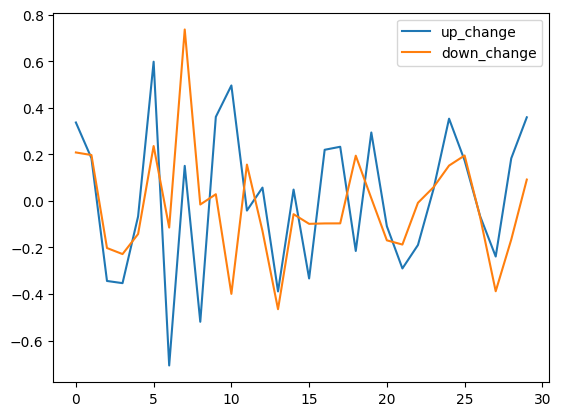

In [83]:
plt.plot(up_values["change"], label="up_change")
plt.plot(down_values["change"], label="down_change")
plt.legend()

In [96]:
for i,df in enumerate(dfs.values():
    if i == 0:
        all_df = df
    else:
        all_df = pd.concat(all_df, df)

In [95]:
all_df

,datetime,open,high,low,close,volume,label,change
0,2010-01-04,4080.0,4090.0,4049.0,4057.0,321838,0,0.000000
1,2010-01-05,4067.0,4082.0,4060.0,4066.0,253640,0,0.221348
2,2010-01-06,4066.0,4194.0,4057.0,4154.0,860812,1,2.118440
3,2010-01-07,4165.0,4188.0,3975.0,4044.0,705704,0,-2.720079
4,2010-01-08,4040.0,4050.0,3947.0,3981.0,526594,0,-1.582517
...,...,...,...,...,...,...,...,...
3051,2022-07-26,22760.0,23135.0,22640.0,23110.0,100407,1,1.514496
3052,2022-07-27,22975.0,22980.0,22535.0,22720.0,151061,0,-1.716549
3053,2022-07-28,22710.0,23635.0,22590.0,23610.0,193936,1,3.769589
3054,2022-07-29,23610.0,23980.0,23430.0,23975.0,203701,1,1.522419


# train

In [154]:
def get_feature_df(df):
    # 相对前日涨跌幅
    close_change = df.loc[1:,"close"].values - df.loc[:(df.shape[0]-2),"close"].values
    close_change = np.hstack([[0], close_change])
    df["label"] = (df["close"] - df["open"]).apply(lambda x:1 if x>0 else 0)
    df["close_change"] = (close_change / df.loc[:,"close"].values) * 100

    # open 相对前日 close
    open_close_change = df.loc[1:,"open"].values - df.loc[:(df.shape[0]-2),"close"].values
    open_close_change = np.hstack([[0], open_close_change])
    df["open_close_change"] = (open_close_change / df.loc[:,"close"].values) * 100

    def get_change(df, base="open"):
        base_change = df.loc[1:,base].values - df.loc[:(df.shape[0]-2),base].values
        base_change = np.hstack([[0], base_change])
        return (base_change / df.loc[:,base].values) * 100
        
    for col in ["open","high","low","volume"]:
        df[col+"_change"] = get_change(df, base=col)
    df["volume_change"].replace(-np.inf, 0, inplace=True)

    # 当日：开盘 收盘 最高 最低 差值 波动, 以开盘价和收盘价为基准
    df["high_open_rate"] = (df["high"] - df["open"]) / df["open"]
    df["low_open_rate"] = (df["low"] - df["open"]) / df["open"]
    df["close_open_rate"] = (df["close"] - df["open"]) / df["open"]
    df["high_close_rate"] = (df["high"] - df["close"]) / df["close"]
    df["low_close_rate"] = (df["low"] - df["close"]) / df["close"]

    df = df.drop(["open","high","low","close","volume"], axis=1)
    return df

def split_sequences(df, window=60, step=1):
    X,y = [],[]
    for i in range(0, df.shape[0]-window-1, step):
        X.append(df.drop("label",axis=1).iloc[i:window+i,:].values)
        y.append(df.loc[i+window,"label"])

    return np.array(X), np.array(y)
    

from functools import reduce
def vstack_array(arrays):
    return reduce(lambda x, y: np.vstack([x,y]), arrays)
def hstack_array(arrays):
    return reduce(lambda x, y: np.hstack([x,y]), arrays)
    
# train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]
# for i,df in enumerate(dfs.values()):
#     df = get_feature_df(df)
#     train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
#     valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
#     test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

#     train_x, train_y = split_sequences(df=deepcopy(train_df.drop(["datetime"], axis=1)))
#     valid_x, valid_y = split_sequences(df=deepcopy(valid_df.drop(["datetime"], axis=1)))
#     test_x, test_y = split_sequences(df=deepcopy(test_df.drop(["datetime"], axis=1)))
    
#     if len(train_y) > 0:
#         train_X.append(train_x)
#         train_Y.append(train_y)
#     if len(valid_y) > 0:
#         valid_X.append(valid_x)
#         valid_Y.append(valid_y)
#     if len(test_y) > 0:
#         test_X.append(test_x)
#         test_Y.append(test_y)
    
train_data, valid_data, test_data = (
            (vstack_array(train_X), hstack_array(train_Y)),
            (vstack_array(valid_X), hstack_array(valid_Y)),
            (vstack_array(test_X), hstack_array(test_Y)),
        )

In [156]:
train_data[0].shape, valid_data[0].shape, test_data[0].shape

((105897, 60, 11), (3905, 60, 11), (4792, 60, 11))

In [8]:

sys.path.append("D:/quant")
from models import LSTMModel, LSTM, ALSTM, TCN

model = ALSTM(d_feat=train_data[0].shape[2], log_path="./")
model.fit(train_data,
        valid_data,
        save_path="D:/quant/checkpoint/model.pt")

preds = model.predict(test_data[0])
print(preds.shape)

D:\anaconda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-08-25 08:53:02,873 - alstm.py[line:57] - INFO: ALSTM pytorch version...
2022-08-25 08:53:02,873 - alstm.py[line:74] - INFO: ALSTM parameters setting:
d_feat : 11
hidden_size : 64
num_layers : 2
dropout : 0.0
n_epochs : 200
lr : 0.001
metric : 
batch_size : 32
early_stop : 20
optimizer : adam
loss_type : mse
device : cpu
use_GPU : False
seed : None
2022-08-25 08:53:02,873 - alstm.py[line:117] - INFO: model:
ALSTMModel(
  (net): Sequential(
    (fc_in): Linear(in_features=11, out_features=64, bias=True)
    (act): Tanh()
  )
  (rnn): GRU(64, 64, num_layers=2, batch_first=True)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (att_net): Sequential(
    (att_fc_in): Linear(in_features=64, out_features=32, bias=True)
    (att_dropout): Dro

(108,)


In [16]:
preds.shape, test_data[1].shape, test_df.shape

((108,), (108,), (139, 12))

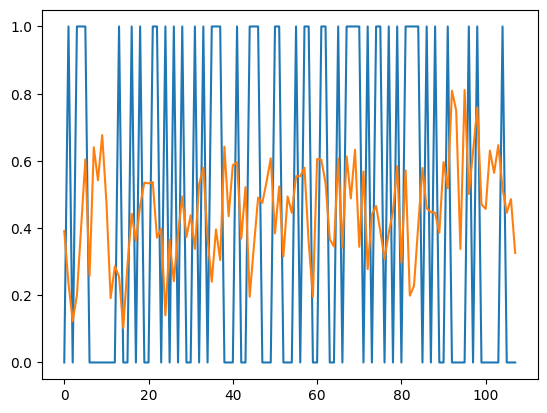

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(len(preds)), test_data[1])

plt.plot(range(len(preds)), preds)

In [166]:
import torch

sys.path.append("D:/quant")
from models import LSTMModel, LSTM, ALSTM, TCN

model = LSTMModel(11, 16)
model.load_state_dict(torch.load("D:\quant\checkpoint\model.pt"))

<All keys matched successfully>

In [168]:
test_data

(array([[[-5.30186420e-01, -2.22336241e-01,  3.41005968e-02, ...,
          -3.06905371e-03,  3.59158543e-03, -3.33504361e-02],
         [ 5.61224490e-01,  0.00000000e+00, -3.07850180e-01, ...,
           5.64391996e-03,  2.38095238e-03, -9.52380952e-03],
         [-5.30005129e-01,  3.07744914e-01,  8.64699898e-01, ...,
          -8.30790098e-03,  1.35065823e-02, -2.22260215e-03],
         ...,
         [ 1.66139241e+00,  3.00632911e-01,  1.57202438e+00, ...,
           1.37953160e-02,  3.48101266e-03, -1.66139241e-02],
         [-2.69712835e-01,  0.00000000e+00,  1.36075949e+00, ...,
          -2.68987342e-03,  6.02887514e-03, -4.60098366e-03],
         [-3.98215992e-01,  1.59286397e-02, -2.53807107e-01, ...,
          -4.12436548e-03,  8.60146543e-03, -2.86715514e-03]],
 
        [[ 5.61224490e-01,  0.00000000e+00, -3.07850180e-01, ...,
           5.64391996e-03,  2.38095238e-03, -9.52380952e-03],
         [-5.30005129e-01,  3.07744914e-01,  8.64699898e-01, ...,
          -8.30790098

In [182]:
model(torch.tensor(test_data[0], dtype=torch.float32)).detach().numpy()

array([0.5097682 , 0.50293046, 0.49941763, ..., 0.48867923, 0.5125513 ,
       0.4612064 ], dtype=float32)

In [187]:
import akshare as ak
rader_code="AU0"
start_date='2019-01-01'
end_date='2022-08-01'
df =  ak.futures_main_sina(trader_code, start_date=start_date, end_date=end_date).iloc[:, :6]
df.columns = ['datetime','open','high','low','close','volume']

In [205]:

def split_sequences(df, window=60, step=1):
    X = []
    for i in range(0, df.shape[0]-window, step):
        X.append(df.iloc[i:window+i,:].values)

    return np.array(X)

def get_feature(df):
    # 相对前日涨跌幅
    close_change = df.loc[1:,"close"].values - df.loc[:(df.shape[0]-2),"close"].values
    close_change = np.hstack([[0], close_change])
    df["close_change"] = (close_change / df.loc[:,"close"].values) * 100

    # open 相对前日 close
    open_close_change = df.loc[1:,"open"].values - df.loc[:(df.shape[0]-2),"close"].values
    open_close_change = np.hstack([[0], open_close_change])
    df["open_close_change"] = (open_close_change / df.loc[:,"close"].values) * 100

    def get_change(df, base="open"):
        base_change = df.loc[1:,base].values - df.loc[:(df.shape[0]-2),base].values
        base_change = np.hstack([[0], base_change])
        return (base_change / df.loc[:,base].values) * 100
        
    for col in ["open","high","low","volume"]:
        df[col+"_change"] = get_change(df, base=col)
    df["volume_change"].replace(-np.inf, 0, inplace=True)

    # 当日：开盘 收盘 最高 最低 差值 波动, 以开盘价和收盘价为基准
    df["high_open_rate"] = (df["high"] - df["open"]) / df["open"]
    df["low_open_rate"] = (df["low"] - df["open"]) / df["open"]
    df["close_open_rate"] = (df["close"] - df["open"]) / df["open"]
    df["high_close_rate"] = (df["high"] - df["close"]) / df["close"]
    df["low_close_rate"] = (df["low"] - df["close"]) / df["close"]

    df = df.drop(["open","high","low","close","volume"], axis=1)

    test_x = split_sequences(df=df.drop(["datetime"], axis=1))

    return test_x

df.shape, get_feature(deepcopy(df)).shape

((868, 6), (808, 60, 11))

In [206]:
feature_data =  get_feature(deepcopy(df))

In [207]:
model = LSTMModel(11, 16)
model.load_state_dict(torch.load("D:\quant\checkpoint\model.pt"))
pred = model(torch.tensor(feature_data, dtype=torch.float32)).detach().numpy()

In [208]:
pred.shape, np.hstack([np.zeros(60)+0.5, pred]).shape

((808,), (868,))

In [209]:
256**2 , (256*64 + 256*64)

(65536, 32768)

In [210]:
df["signal"] = np.hstack([np.zeros(60)+0.5, pred])
df.head()

,datetime,open,high,low,close,volume,signal
0,2019-01-02,287.55,288.70,287.15,288.30,91402,0.5
1,2019-01-03,288.45,290.75,287.90,290.70,198374,0.5
2,2019-01-04,289.95,291.60,289.35,290.55,217562,0.5
3,2019-01-07,290.00,290.15,286.90,288.65,280434,0.5
4,2019-01-08,289.00,289.70,286.90,287.25,193804,0.5


# corr

In [2]:
""" 候选品种
TA0 czce    PTA连续
MA0	czce	甲醇连续
RM0	czce	菜粕连续
C0  dce     玉米连续
"""

dfs = {}
symbols = []
future_list = glob.glob("D:/quant/data/futures/*")
future_list = sorted(future_list, key = lambda x: pathlib.Path(x).name[:-4].split(".")[-1])
for i in future_list:
    symbol = pathlib.Path(i).name[:-4]
    # if symbol == "AU0.shfe":
    df = pd.read_csv(i)
    if df.shape[0] > 100:
        dfs[symbol] = df
        symbols.append(symbol)
    # break

      IC0.cffex  IF0.cffex  IH0.cffex  TF0.cffex  TS0.cffex  AP0.czce  \
0        6065.0     3315.4     2325.6     99.075     99.160    8117.0   
1        6073.8     3345.0     2345.0     99.100     99.215    8095.0   
2        6047.0     3326.0     2334.0     99.355     99.185    8090.0   
3        6082.8     3353.0     2349.8     99.470     99.200    8086.0   
4        6114.2     3352.0     2346.8     99.425     99.275    8104.0   
...         ...        ...        ...        ...        ...       ...   
1340     6273.4     4235.8     2851.0    101.770        NaN       NaN   
1341     6298.0     4213.0     2827.2    101.730        NaN       NaN   
1342     6305.6     4214.8     2823.8    101.590        NaN       NaN   
1343     6255.2     4152.4     2784.8    101.800        NaN       NaN   
1344     6311.4     4174.0     2778.0    101.880        NaN       NaN   

      CF0.czce  CJ0.czce  CY0.czce  FG0.czce  ...  HC0.shfe  NI0.shfe  \
0        16610    8665.0   23070.0      1319  ... 

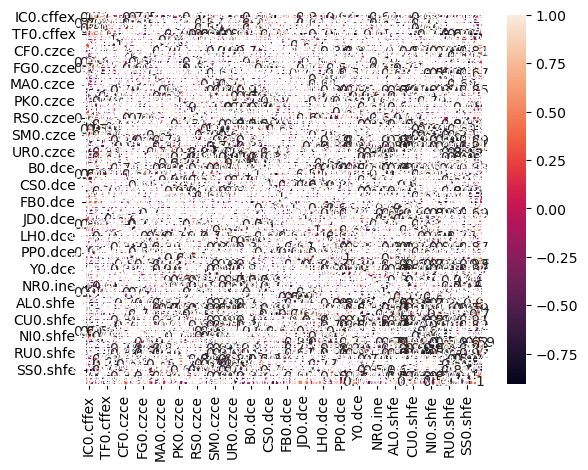

In [6]:
symbols = dfs.keys()
df_Close = pd.DataFrame()

for symbol in symbols:
    df_Close[symbol] = dfs[symbol]["close"]
print(df_Close)

import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(df_Close.corr(), ax=ax, annot=True)
plt.show()

In [14]:
for i,j in zip(df_Close.corr()["TA0.czce"].index, df_Close.corr()["TA0.czce"]):
    print(i,j)

IC0.cffex -0.39979639765403596
IF0.cffex -0.4802069072797077
IH0.cffex -0.39568068027812137
TF0.cffex -0.6810767999747606
TS0.cffex -0.005150584372368371
AP0.czce 0.35643164232848173
CF0.czce 0.9033820980400046
CJ0.czce -0.5066810831309164
CY0.czce -0.18692479149300248
FG0.czce -0.3497444353189401
JR0.czce 0.46710189083225256
LR0.czce -0.2773972676446961
MA0.czce -0.02464134545815492
OI0.czce 0.8278495811118682
PF0.czce 0.23569660901826092
PK0.czce -0.19166037392387775
RI0.czce 0.2535737331707297
RM0.czce 0.15383703816035782
RS0.czce -0.024694734186222558
SA0.czce -0.1709701570372898
SF0.czce -0.4961360106042546
SM0.czce -0.5212382575311894
SR0.czce 0.7510955510437847
TA0.czce 1.0
UR0.czce -0.39580439799230904
ZC0.czce -0.24719532154743015
A0.dce 0.1821823203319697
B0.dce 0.8072568968144728
BB0.dce -0.47139693631377744
C0.dce -0.11616021827154356
CS0.dce -0.29391336116293265
EB0.dce -0.19515905186970384
EG0.dce -0.3890647143361823
FB0.dce -0.7092544195873236
I0.dce -0.06858862185323224